In [1]:
using SymPy

In [2]:
function grad(f, x)
    [diff(f, x[i]) for i in 1:length(x)]
end

grad (generic function with 1 method)

In [3]:
function define_field(x, phi, vs, lambdas, betas)
    num_points = length(lambdas)
    @assert length(vs) == length(lambdas)
    @assert length(betas) == length(lambdas)
    @assert num_points >= 1
    
    d = 0 * lambdas[1]
    for i = 1:num_points
        phi_expr = phi(norm(x - vs[i]))
        d += lambdas[i] * phi_expr + dot(betas[i], grad(phi_expr, x))[1]
    end
    d
end

define_field (generic function with 1 method)

In [4]:
points = Any[[1,0], [0,1], [-1, 0], [0, -1]]
normals = Any[[1,0], [0,1], [-1, 0], [0, -1]]

4-element Array{Any,1}:
 [1,0] 
 [0,1] 
 [-1,0]
 [0,-1]

In [89]:
dimension = 2
num_points = length(points)
lambdas = [symbols("lambda$(i)", real=true) for i in 1:num_points]
x = Sym[symbols("x$(i)", real=true) for i in 1:dimension]
vs = [Sym[symbols("v$(j)_$(i)", real=true) for i in 1:dimension] for j in 1:num_points]
betas = [Sym[symbols("beta$(j)_$(i)", real=true) for i in 1:dimension] for j in 1:num_points]
phi = x -> x^3
d = define_field(x, phi, vs, lambdas, betas)
# g = grad(d, x)
# exs = Sym[]
# for i = 1:num_points
#     push!(exs, d([x[j] => points[i][j] for j = 1:dimension]...))
#     for j = 1:dimension
#         push!(exs, g[1]([x[j] => points[i][j]]...) - normals[i][j])
#     end
# end
# solve(exs)

# Define A and b such that A * [lambdas; betas[:]] = b
# A has 1 row for each point and dim rows for each normal
d_at_points = d([vs[i][j] => points[i][j] for i = 1:length(points), j = 1:dimension]...)
A = zeros(0, num_points * (dimension + 1))
b = zeros(0, 1)
for i = 1:num_points
    d_at_v_i = d_at_points([x[k] => points[i][k] for k = 1:dimension]...)
    row = zeros(num_points * (dimension + 1))
    row_index = 1
    for j = 1:num_points
        row[row_index] = diff(d_at_v_i, lambdas[j])
        row_index += 1
    end
    for j = 1:num_points
        for k = 1:dimension
            row[row_index] = diff(d_at_v_i, betas[j][k])
            row_index += 1
        end
    end
    A = [A; row']
    b = [b; 0]
end

g_at_points = grad(d_at_points, x)
@show g_at_points
for i = 1:num_points
    for k = 1:dimension
#         g_at_v_i_k = g_at_points[k]([x[l] => points[i][l] for l = 1:dimension]...)
#         @show g_at_v_i_k
        row = zeros(num_points * (dimension + 1))
        row_index = 1
        for j = 1:num_points
            row[row_index] = diff(g_at_points[k], lambdas[j])([x[l] => points[i][l] for l = 1:dimension]...)
            row_index += 1
        end
        for j = 1:num_points
            for l = 1:dimension
                row[row_index] = diff(g_at_points[k], betas[j][l])([x[l] => points[i][l] for l = 1:dimension]...)
                if isnan(row[row_index])
                    row[row_index] = 0.0
                end
                row_index += 1
            end
        end
        A = [A; row']
        b = [b; normals[i][k]]
    end
end

y = A \ b
lambda_values = y[1:num_points]
d_result = d_at_points
beta_values = reshape(y[num_points+1:end], dimension, num_points)'
for i = 1:num_points
    d_result = d_result(lambdas[i] => lambda_values[i])
    for j = 1:dimension
        d_result = d_result(betas[i][j] => beta_values[i,j])
    end
end
d_result = lambdify(d_result, x)

g_at_points = Any[beta1_1*(x1 - 1)*(3*x1 - 3)/sqrt(x2^2 + (-x1 + 1)^2) + 3*beta1_1*sqrt(x2^2 + (-x1 + 1)^2) + 3*beta1_2*x2*(x1 - 1)/sqrt(x2^2 + (-x1 + 1)^2) + 3*beta2_1*x1^2/sqrt(x1^2 + (-x2 + 1)^2) + 3*beta2_1*sqrt(x1^2 + (-x2 + 1)^2) + beta2_2*x1*(3*x2 - 3)/sqrt(x1^2 + (-x2 + 1)^2) + beta3_1*(x1 + 1)*(3*x1 + 3)/sqrt(x2^2 + (-x1 - 1)^2) + 3*beta3_1*sqrt(x2^2 + (-x1 - 1)^2) + 3*beta3_2*x2*(x1 + 1)/sqrt(x2^2 + (-x1 - 1)^2) + 3*beta4_1*x1^2/sqrt(x1^2 + (-x2 - 1)^2) + 3*beta4_1*sqrt(x1^2 + (-x2 - 1)^2) + beta4_2*x1*(3*x2 + 3)/sqrt(x1^2 + (-x2 - 1)^2) + lambda1*(3*x1 - 3)*sqrt(x2^2 + (-x1 + 1)^2) + 3*lambda2*x1*sqrt(x1^2 + (-x2 + 1)^2) + lambda3*(3*x1 + 3)*sqrt(x2^2 + (-x1 - 1)^2) + 3*lambda4*x1*sqrt(x1^2 + (-x2 - 1)^2),beta1_1*x2*(3*x1 - 3)/sqrt(x2^2 + (-x1 + 1)^2) + 3*beta1_2*x2^2/sqrt(x2^2 + (-x1 + 1)^2) + 3*beta1_2*sqrt(x2^2 + (-x1 + 1)^2) + 3*beta2_1*x1*(x2 - 1)/sqrt(x1^2 + (-x2 + 1)^2) + 3*beta2_2*sqrt(x1^2 + (-x2 + 1)^2) + beta2_2*(x2 - 1)*(3*x2 - 3)/sqrt(x1^2 + (-x2 + 1)^2) + beta3

##9797 (generic function with 1 method)

In [90]:
using PyPlot

INFO: Recompiling stale cache file /home/rdeits/.julia/lib/v0.4/PyPlot.ji for module PyPlot.
INFO: Recompiling stale cache file /home/rdeits/.julia/lib/v0.4/LaTeXStrings.ji for module LaTeXStrings.
INFO: Loading additional PyPlot commands for graphing for SymPy objects:
quiver, contour3D, and plot_implicit.
See ?sympy_plotting for some more details


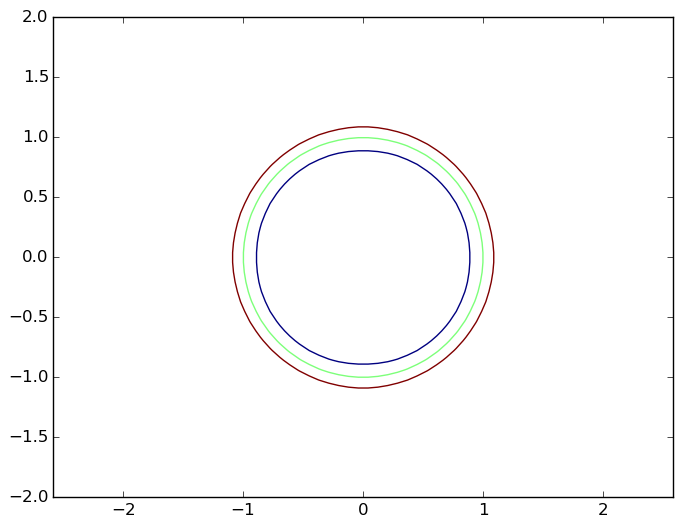

(-2.0,2.0,-2.0,2.0)

In [94]:
X = linspace(-2, 2)
Y = linspace(-2, 2)
Z = zeros(length(X), length(Y))
for i = 1:length(X)
    for j = 1:length(Y)
        Z[i,j] = d_result(X[i], Y[j])
    end
end
PyPlot.contour(X, Y, Z, [-0.1, 0.0, 0.1])
axis("equal")